In [1]:
import sys
import numpy as np

from PySDM.backends import CPU, GPU
from PySDM.builder import Builder
from PySDM.environments import Box
from PySDM.dynamics import Coalescence
from PySDM.dynamics import Breakup
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity

from PySDM.products.state import ParticlesVolumeSpectrum, ParticlesConcentration, ParticleMeanRadius, KMoments
from PySDM.products.stats.timers import WallTime

from matplotlib import pyplot

In [2]:
from PySDM.initialisation.spectra import Exponential
from PySDM.physics.coalescence_kernels import ConstantK, Golovin
from PySDM.physics.breakup_fragmentations import AlwaysN, SLAMS
from PySDM.physics.coalescence_efficiencies import ConstEc, Berry1967
from PySDM.physics.constants import si
from PySDM.physics.formulae import Formulae
from pystrict import strict

@strict
class Settings:

    def __init__(self):
        self.formulae = Formulae()
        self.n_sd = 2**12
        self.n_part = 100 / si.cm**3
        self.X0 = self.formulae.trivia.volume(radius=30.531 * si.micrometres)
        self.dv = 1 * si.m**3
        self.norm_factor = self.n_part * self.dv
        self.rho = 1000 * si.kilogram / si.metre**3
        self.dt = 1 * si.seconds
        self.adaptive = False
        self.seed = 123
        self._steps = [0, 1, 2]
        self.kernel = Golovin(b=1500e3 / si.second)
        self.coal_eff = ConstEc(0.5)
        self.fragmentation = SLAMS()
        self.spectrum = Exponential(norm_factor=self.norm_factor, scale=self.X0)
        self.radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(100 * si.um), num=128, endpoint=True)
        self.radius_range = [0 * si.um, 1e6 * si.um]

    @property
    def output_steps(self):
        return [int(step/self.dt) for step in self._steps]

[27.26100979] [99.997952] [9.99979520e+07 1.19039437e-05 2.81166517e-18]
[19.20752039] [276.556836] [2.76556836e+08 1.19039471e-05 1.25200497e-18]
[16.57558531] [457.021893] [4.57021893e+08 1.19039424e-05 7.09717854e-19]


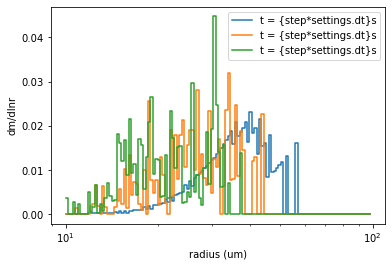

In [3]:
settings = Settings()
backend = GPU

builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Breakup(settings.kernel, settings.coal_eff, settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range), KMoments()]
core = builder.build(attributes, products)

for step in settings.output_steps:
    #print(step, flush=True)
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post', label="t = {step*settings.dt}s")
    print(core.products['radius_m1'].get(), core.products['n_a_cm3'].get(), core.products['M0-Mk'].get(3))
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")
pyplot.legend()

/home/edejong/.local/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


[27.26101585] [99.997952] [9.99979520e+07 1.19039420e-05 2.81166553e-18]
[ 2  2  3 20  2 11  2  3  6  5 18  3 17 16  7  2  9 14  4  2  2 11  2  4
  2  2 21  2  6  8  2  2  8  3  2  2 21  5  4  2 14  3  9 14  2 21 13  4
  7  2  7  3  3  6  3  6 11  2  2  3  3  7  3  6 23  2  8  4  3  5  2  3
  2  5  2  2  2  8  6 11  6  2  6  4 19  2  2 10  3  3  7  2  3  9  5 14
 12  2  9  5  2  2  8 11  2  6  3  2  2  2  3  2  5 10  3  5 10 10  3  4
  4  2  2  2  2 18 14 10] [0.30862748 0.30862748 0.47258534 0.97655668 0.30862748 0.86218913
 0.30862748 0.47258534 0.70676381 0.65115733 0.95884794 0.47258534
 0.94882912 0.93787592 0.75048465 0.30862748 0.8155249  0.91252133
 0.57725669 0.30862748 0.30862748 0.86218913 0.30862748 0.57725669
 0.30862748 0.30862748 0.98443401 0.30862748 0.70676381 0.78598405
 0.30862748 0.30862748 0.78598405 0.47258534 0.30862748 0.30862748
 0.98443401 0.65115733 0.57725669 0.30862748 0.91252133 0.47258534
 0.8155249  0.91252133 0.30862748 0.98443401 0.89769336 0.57725669


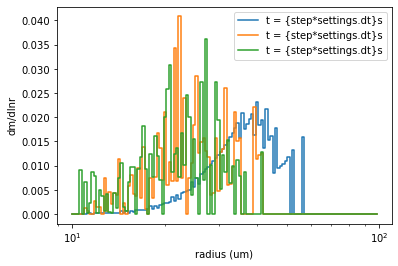

In [4]:
settings = Settings()
backend = CPU

builder = Builder(n_sd=settings.n_sd, backend=backend, formulae=settings.formulae)
builder.set_environment(Box(dv=settings.dv, dt=settings.dt))
attributes = {}
attributes['volume'], attributes['n'] = ConstantMultiplicity(settings.spectrum).sample(settings.n_sd)
breakup = Breakup(settings.kernel, settings.coal_eff, settings.fragmentation, adaptive=settings.adaptive)
builder.add_dynamic(breakup)
products = [ParticlesVolumeSpectrum(), WallTime(), ParticleMeanRadius(), ParticlesConcentration(radius_range = settings.radius_range), KMoments()]
core = builder.build(attributes, products)

for step in settings.output_steps:
    #print(step, flush=True)
    core.run(step - core.n_steps)
    pyplot.step(x=settings.radius_bins_edges[:-1] / si.micrometres, 
                y=core.products['dv/dlnr'].get(settings.radius_bins_edges) * settings.rho,
                where='post', label="t = {step*settings.dt}s")
    print(core.products['radius_m1'].get(), core.products['n_a_cm3'].get(), core.products['M0-Mk'].get(3))
    
pyplot.xscale("log")
pyplot.xlabel("radius (um)")
pyplot.ylabel("dm/dlnr")
pyplot.legend()